In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)
import warnings
warnings.filterwarnings('ignore')

___
## 시계열 예측모델 : ARMA, ARIMA, SARIMA, VAR, VARMA 
___

In [3]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# helper 함수 정의
def adf_test(series):
    result = adfuller(series)
    print(f'- ADF 통계량: {result[0]}')
    print(f'- p-value: {result[1]} ({'정상성 있음' if result[1] < 0.05 else '정상성 없음'})')
    print(f'- 지연수: {result[2]}')
    print(f'- 관찰수: {result[3]}')
    print('- 임계값:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    

In [33]:
# 데이터 로드
df = pd.read_csv('Data/moneystock-spending-series.csv', index_col=0, parse_dates=True)
df.index.freq = 'MS'

## 1. 단일 시계열 분석 모델

#### <font color="orange">메타포 설명 : 오늘 기온을 예측하기 위해서, 최근7일간의 기온 데이터를 활용한다. 즉, 타겟변수를 예측할때 그 히스토리만 활용한다. </font>

### ARMA / ARIMA (Autoregressive Integrated Moving Average) 모델
___

ARMA 모델은 자기회귀(AR)와 이동 평균(MA) 성분을 결합한 모델

ARIMA 모델은 비정상적인 시계열 데이터를 다루기 위해 ARMA 모델에 차분(I) 성분을 추가한 모델.

* AR(p): 자기회귀 성분. 현재 값이 이전 (p)개의 값에 의해 설명됨.

* MA(q): 이동 평균 성분. 현재 값이 이전 q개의 오류 항에 의해 설명됨.
* I(d): 차분 성분. 데이터를 (d)번 차분하여 정상화함.


 $Y_t = c + \epsilon_t + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} $

 $\Phi(B) (1 - B)^d y_t = \Theta(B) \varepsilon_t$


$\textcolor{orange}{B}$: 백시프트 연산자 $(B y_t = y_{t-1})$

$\textcolor{orange}{\Phi(B)}$: AR(자기회귀) 다항식  $(\Phi(B) = 1 - \phi_1 B - \phi_2 B^2 - \cdots - \phi_p B^p)$

$\textcolor{orange}{(1 - B)^d}$: $d$번의 차분 연산

$\textcolor{orange}{\Theta(B)}$: MA(이동평균) 다항식 $(\Theta(B) = 1 - \theta_1 B - \theta_2 B^2 - \cdots - \theta_q B^q)$


* 사용 예시

In [39]:
data = df['Money']
# ARIMA (1, 2, 1) 모델 피팅
model = ARIMA(data, order=(1, 2, 1))
fitted_model = model.fit()
print(fitted_model.summary())
# 예측
forecast = fitted_model.forecast(steps=12)
print(forecast)

                               SARIMAX Results                                
Dep. Variable:                  Money   No. Observations:                  252
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1176.729
Date:                Thu, 13 Jun 2024   AIC                           2359.458
Time:                        16:06:53   BIC                           2370.023
Sample:                    01-01-1995   HQIC                          2363.710
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2229      0.042      5.297      0.000       0.140       0.305
ma.L1         -0.9481      0.021    -45.132      0.000      -0.989      -0.907
sigma2       712.5495     33.501     21.270      0.0

### SARIMA (Seasonal ARIMA) 모델
___

SARIMA 모델은 ARIMA 모델에 계절성 성분을 추가한 모델. 

계절성이 있는 비정상적인 시계열 데이터를 다루는 데 사용됨.

* 계절성 성분(s): 계절적 AR, I, MA 성분을 추가함.

 $\Phi(B) \textcolor{orange}{\Phi_s(B^s)} (1 - B)^d \textcolor{orange}{(1 - B^s)^D} y_t = \Theta(B) \textcolor{orange}{\Theta_s(B^s)} \varepsilon_t$


In [40]:
# SARIMA (1, 1, 1)x(1, 1, 1, 12) 모델 피팅
sarima_model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) # SARIMAX는 SARIMA에서 외생변수 처리까지 구현된 클래스
sarima_fitted_model = sarima_model.fit()
print(sarima_fitted_model.summary())
# 예측
sarima_forecast = sarima_fitted_model.forecast(steps=12)
print(sarima_forecast)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66316D+00    |proj g|=  9.48355D-02


 This problem is unconstrained.



At iterate    5    f=  4.61787D+00    |proj g|=  1.61608D-02

At iterate   10    f=  4.59571D+00    |proj g|=  2.62111D-02

At iterate   15    f=  4.56628D+00    |proj g|=  3.69882D-02

At iterate   20    f=  4.55041D+00    |proj g|=  2.48261D-03

At iterate   25    f=  4.54616D+00    |proj g|=  2.03493D-02

At iterate   30    f=  4.54576D+00    |proj g|=  1.41584D-04

At iterate   35    f=  4.54575D+00    |proj g|=  2.19529D-04

At iterate   40    f=  4.54574D+00    |proj g|=  5.28892D-04

At iterate   45    f=  4.54574D+00    |proj g|=  1.66815D-04

At iterate   50    f=  4.54574D+00    |proj g|=  3.75477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/dante/lecture/kmu-practical-ds-2024/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



___
## 2. 다변량 시계열 분석 모델

#### <font color="orange">메타포 설명 : 오늘 기온을 예측하기 위해서, 최근 7일간의 기온 데이터 뿐 아니라, 7일간의 풍속, 습도 데이터를 활용한다. </font>

#### <font color="orange">즉, 타겟변수를 예측할때 해당변수 및 해당변수와 연관된 변수의 히스토리까지 고려한다. </font>

___
### VAR (Vector Autoregression) 모델 (벡터 자기회귀 모형)
___
VAR 모델은 다변량 시계열 데이터를 다루는 모델. 

각 시계열 변수는 다른 변수들과의 관계를 고려하여 모델링됨.

$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$


* <font color="orange"> 2차원 VAR(1) 모델 예시</font>

    $y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
    
    $y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

    #### $\begin{pmatrix} y_{1,t} \\ y_{2,t} \end{pmatrix} = \begin{pmatrix} c_1 \\ c_2 \end{pmatrix} + \begin{pmatrix} \phi_{11,1} & \phi_{12,1} \\ \phi_{21,1} & \phi_{22,1} \end{pmatrix} \begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \end{pmatrix} + \begin{pmatrix} \varepsilon_{1,t} \\ \varepsilon_{2,t} \end{pmatrix} $

* <font color="orange"> 3차원 VAR(2) 모델 예시 </font>

    $y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{13,1}y_{3,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{13,2}y_{3,t-2} + \varepsilon_{1,t}$<br>

    $y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{23,1}y_{3,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{23,2}y_{3,t-2} + \varepsilon_{2,t}$<br>

    $y_{3,t} = c_3 + \phi_{31,1}y_{1,t-1} + \phi_{32,1}y_{2,t-1} + \phi_{33,1}y_{3,t-1} + \phi_{31,2}y_{1,t-2} + \phi_{32,2}y_{2,t-2} + \phi_{33,2}y_{3,t-2} + \varepsilon_{3,t}$<br><br>

    #### $ \begin{pmatrix} y_{1,t} \\ y_{2,t} \\ y_{3,t} \end{pmatrix} = \begin{pmatrix} c_1 \\ c_2 \\ c_3 \end{pmatrix} + \begin{pmatrix} \phi_{11,1} & \phi_{12,1} & \phi_{13,1} \\ \phi_{21,1} & \phi_{22,1} & \phi_{23,1} \\ \phi_{31,1} & \phi_{32,1} & \phi_{33,1} \end{pmatrix} \begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \\ y_{3,t-1} \end{pmatrix} + \begin{pmatrix} \phi_{11,2} & \phi_{12,2} & \phi_{13,2} \\ \phi_{21,2} & \phi_{22,2} & \phi_{23,2} \\ \phi_{31,2} & \phi_{32,2} & \phi_{33,2} \end{pmatrix} \begin{pmatrix} y_{1,t-2} \\ y_{2,t-2} \\ y_{3,t-2} \end{pmatrix} + \begin{pmatrix} \varepsilon_{1,t} \\ \varepsilon_{2,t} \\ \varepsilon_{3,t} \end{pmatrix} $

* 모델 사용 예시

In [38]:
# VAR 모델 피팅
model = VAR(df)
fitted_model = model.fit(maxlags=15, ic='aic')

# 모델 요약 출력
print(fitted_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Jun, 2024
Time:                     15:35:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8778
Nobs:                     247.000    HQIC:                   13.6911
Log likelihood:          -2354.26    FPE:                    778666.
AIC:                      13.5652    Det(Omega_mle):         713683.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -3.578575        10.765839           -0.332           0.740
L1.Money            1.166264         0.064984           17.947           0.000
L1.Spending        -0.128001         0.049702           -2.575      

___
### VARMA (Vector Autoregression Moving Average) 모델 (벡터 자기회귀 이동평균 모델)
___

VARMA 모델은 다변량 시계열 데이터를 다루며, VAR 모델에 이동 평균 성분을 추가한 모델

$ Y_t = c + A_1 Y_{t-1} + A_2 Y_{t-2} + \cdots + A_p Y_{t-p} + \epsilon_t \textcolor{orange}{+ \sum_{j=1}^{q} \Theta_j \epsilon_{t-j}} $


* <font color="orange"> 2차원 VARMA(2,1) 모델 예시 </font>

#### $\begin{pmatrix} y_{1,t} \\ y_{2,t} \end{pmatrix}\begin{pmatrix} c_1 \\ c_2 \end{pmatrix}+\begin{pmatrix} \phi_{11,1} & \phi_{12,1} \\ \phi_{21,1} & \phi_{22,1} \end{pmatrix}\begin{pmatrix} y_{1,t-1} \\ y_{2,t-1} \end{pmatrix}+\begin{pmatrix} \phi_{11,2} & \phi_{12,2} \\ \phi_{21,2} & \phi_{22,2} \end{pmatrix}\begin{pmatrix} y_{1,t-2} \\ y_{2,t-2} \end{pmatrix} \textcolor{orange}{+\begin{pmatrix} \theta_{11,1} &\theta_{12,1} \\ \theta_{21,1} & \theta_{22,1} \end{pmatrix}\begin{pmatrix} \varepsilon_{1,t-1} \\ \varepsilon_{2,t-1} \end{pmatrix}}+\begin{pmatrix} \varepsilon_{1,t} \\ \varepsilon_{2,t} \end{pmatrix}$

In [36]:
# VARMA 모델 피팅
model = VARMAX(df, order=(2, 1))
fitted_model = model.fit(disp=False)

# 모델 요약 출력
print(fitted_model.summary())

# 예측
n_forecast = 10
forecast = fitted_model.forecast(steps=n_forecast)
print(forecast)


/Users/dante/lecture/kmu-practical-ds-2024/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



                             Statespace Model Results                            
Dep. Variable:     ['Money', 'Spending']   No. Observations:                  252
Model:                        VARMA(2,1)   Log Likelihood               -2448.365
                             + intercept   AIC                           4930.729
Date:                   Thu, 13 Jun 2024   BIC                           4990.730
Time:                           15:34:59   HQIC                          4954.872
Sample:                       01-01-1995                                         
                            - 12-01-2015                                         
Covariance Type:                     opg                                         
Ljung-Box (L1) (Q):             0.05, 4.06   Jarque-Bera (JB):       395.41, 118.80
Prob(Q):                        0.83, 0.04   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.41, 0.87   Skew:                       1.09, 0.12
Prob(H) (t

/Users/dante/lecture/kmu-practical-ds-2024/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



----
----

| 특징        | ARIMA                                      | VARMA                                           |
|-------------|--------------------------------------------|-------------------------------------------------|
| 데이터 유형 | 단일 시계열 데이터                         | 다중 시계열 데이터                              |
| 구성 요소   | AR (자기회귀), I (차분), MA ㅡ(이동평균)     | VAR (벡터 자기회귀), VMA (벡터 이동평균)        |
| 모델 형태   | ARIMA(p, d, q)                             | VARMA(p, q)                                     |
| 적용 예시   | 주식 가격, 온도 변화, 판매량 등            | 경제 지표, 여러 주식의 가격 변동, 기후 데이터 등|

----
----

___
## VAR / AR 예측 모델 실습
___

데이터 시각화

In [9]:
px.line(df, x=df.index, y=df.columns, title="M2 통화량 및 개인 소비").show()

In [ ]:
# 정상성이 전제되어야 ARIMA 계열 모델을 사용할수 있다고 지난 수업시간 설명했습니다.
# 이유는 AR의 경우 타입스텝 각 시점마다 평균과 분산이 일정해야, 바로 이전 타입스텝과의 관계성을 회귀식으로 정의할수 있고,
# MA의 경우, 과거 시점의 오차 값을 이용해서 편재 시점의 값을 예측하는데, 평균 변동성은 오차패턴의 변동성을 만들게 되어, 과거오차 기반 예측이 불안정해지기 때문입니다.

오리지널 데이터 정상성검정

In [12]:
adf_test(df['Money']);
print()
adf_test(df['Spending']);

- ADF 통계량: 4.239022425670647
- p-value: 1.0 (정상성 없음)
- 지연수: 4
- 관찰수: 247
- 임계값:
	1%: -3.457
	5%: -2.873
	10%: -2.573

- ADF 통계량: 0.14979608598625144
- p-value: 0.969300994442831 (정상성 없음)
- 지연수: 3
- 관찰수: 248
- 임계값:
	1%: -3.457
	5%: -2.873
	10%: -2.573


1차 차분 데이터 정상성 검정

In [13]:
# 1차 차분
df_transformed = df.diff().dropna()

In [14]:
adf_test(df_transformed['Money']);
print()
adf_test(df_transformed['Spending']);

- ADF 통계량: -2.0574040497379373
- p-value: 0.2619837978511253 (정상성 없음)
- 지연수: 15
- 관찰수: 235
- 임계값:
	1%: -3.458
	5%: -2.874
	10%: -2.573

- ADF 통계량: -7.226973930850659
- p-value: 2.04102725921286e-10 (정상성 있음)
- 지연수: 2
- 관찰수: 248
- 임계값:
	1%: -3.457
	5%: -2.873
	10%: -2.573


2차 차분 데이터 정상성 검정

In [15]:
# 2차 차분
df_transformed = df_transformed.diff().dropna()
adf_test(df_transformed['Money']);
print()
adf_test(df_transformed['Spending']);

- ADF 통계량: -7.077470794343004
- p-value: 4.760674931296479e-10 (정상성 있음)
- 지연수: 14
- 관찰수: 235
- 임계값:
	1%: -3.458
	5%: -2.874
	10%: -2.573

- ADF 통계량: -8.760145426337745
- p-value: 2.6878999679867176e-14 (정상성 있음)
- 지연수: 8
- 관찰수: 241
- 임계값:
	1%: -3.458
	5%: -2.874
	10%: -2.573


데이터 분할

- 여기서 데이터 분할을 sklearn의 train_test_split 함수 등을 사용하지 않는 이유는, <font color="yellow">시간순 정렬의 shuffle이 일어나서는 안되기 때문</font>입니다.(시계열 분석의 특징)

In [16]:
# 테스트셋의 12개의 타임스텝으로 만들고, 예측시, 이 12개의 타임스텝을 싱글샷으로 예측할 예정입니다.
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [17]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


AIC지표 기반 VAR 최적모델 파인더 실행

 - AIC (Akaike Information Criterion)
  
   - 값이 낮을수록 더 좋은 모델을 의미.  

   - AIC는 모델의 복잡도와 적합도를 모두 고려하여 계산됩니다.
   - 공식 : $ \text{AIC} = 2k - 2\ln(L) $ ( $k$는 복잡도, $L$은 설명력(우도)을 의미 )

In [18]:
def find_best_model(train, max_order):
    best_aic = float('inf')
    best_order = None
    model = VAR(train)
    for i in range(1, max_order+1):
        results = model.fit(i)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = i
    return model, best_order

model, best_order = find_best_model(train, max_order=7)
print('Best Order =', best_order)

Best Order = 5


In [20]:
# 모델에 있는 변수들의 이름을 확인합니다.
model.endog_names

['Money', 'Spending']

모델링

In [21]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Jun, 2024
Time:                     14:39:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [41]:
print('모델 차수:', results.k_ar)

모델 차수: 5


예측

In [43]:
# 다음 12개의 값을 예측합니다.
forecast = results.forecast(train.values[-results.k_ar:], steps=nobs)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=train.index[-1], periods=nobs+1, freq='MS')[1:], columns=train.columns)

print("Forecasted values for the next 12 periods:")
print(forecast_df)


Forecasted values for the next 12 periods:
                Money   Spending
2015-01-01 -16.995276  36.149820
2015-02-01  -3.174038 -11.450298
2015-03-01  -0.377725  -6.684969
2015-04-01  -2.602233   5.479458
2015-05-01   4.228557  -2.443365
2015-06-01   1.559393   0.387639
2015-07-01  -0.998410   3.883680
2015-08-01   0.364510  -2.356101
2015-09-01  -1.210627  -1.224147
2015-10-01   0.225877   0.786927
2015-11-01   1.338939   0.180974
2015-12-01  -0.218585   0.212750


데이터 역변환

* 예측된 값들은 2차 차분을 나타냄. 원본 데이터와 비교하려면 각 차분을 되돌려야함.

* 1차 차분을 되돌리려면 원본 시리즈의 훈련 부분에서 가장 최근 값을 가져와 예측된 값들의 누적 합에 더해야함.

* 2차 차분을 다룰 때는 먼저 가장 최근의 1차 차분에 대해 이 작업을 수행할 것.


* Money 컬럼 역변환

In [44]:
# 마지막 훈련 데이터 값
train_last_value = df['Money'].iloc[-nobs-1]

# 마지막에서 두 번째 훈련 데이터 값
train_second_last_value = df['Money'].iloc[-nobs-2]

# 두 값의 차이를 계산
money_diff = train_last_value - train_second_last_value

# 예측된 값들의 누적 합을 계산
money2d_cumsum = forecast_df['Money'].cumsum()

# 1차 차분을 되돌린 값을 계산
forecast_df['Money1d'] = money_diff + money2d_cumsum

# 원본 값을 되돌린 예측 값을 계산
forecast_df['MoneyForecast'] = train_last_value + forecast_df['Money1d'].cumsum()


* Speanding 컬럼 역변환

In [45]:
train_last_value = df['Spending'].iloc[-nobs-1]

train_second_last_value = df['Spending'].iloc[-nobs-2]

spending_diff = train_last_value - train_second_last_value

spending2d_cumsum = forecast_df['Spending'].cumsum()

forecast_df['Spending1d'] = spending_diff + spending2d_cumsum

forecast_df['SpendingForecast'] = train_last_value + forecast_df['Spending1d'].cumsum()

In [46]:
forecast_df

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019


결과 시각화

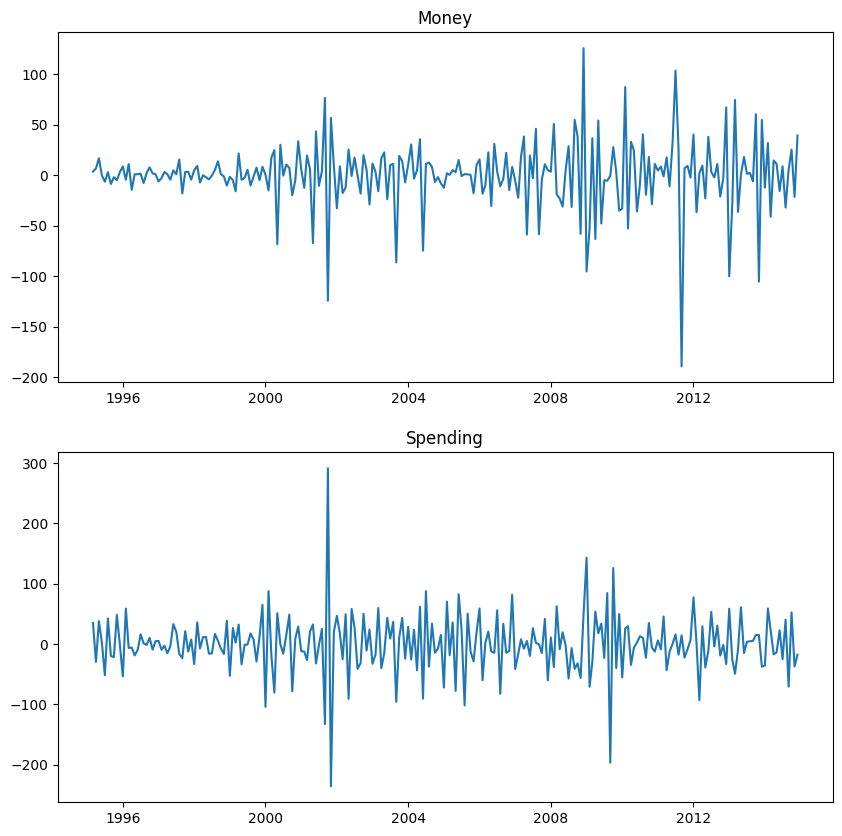

In [54]:
results.plot();

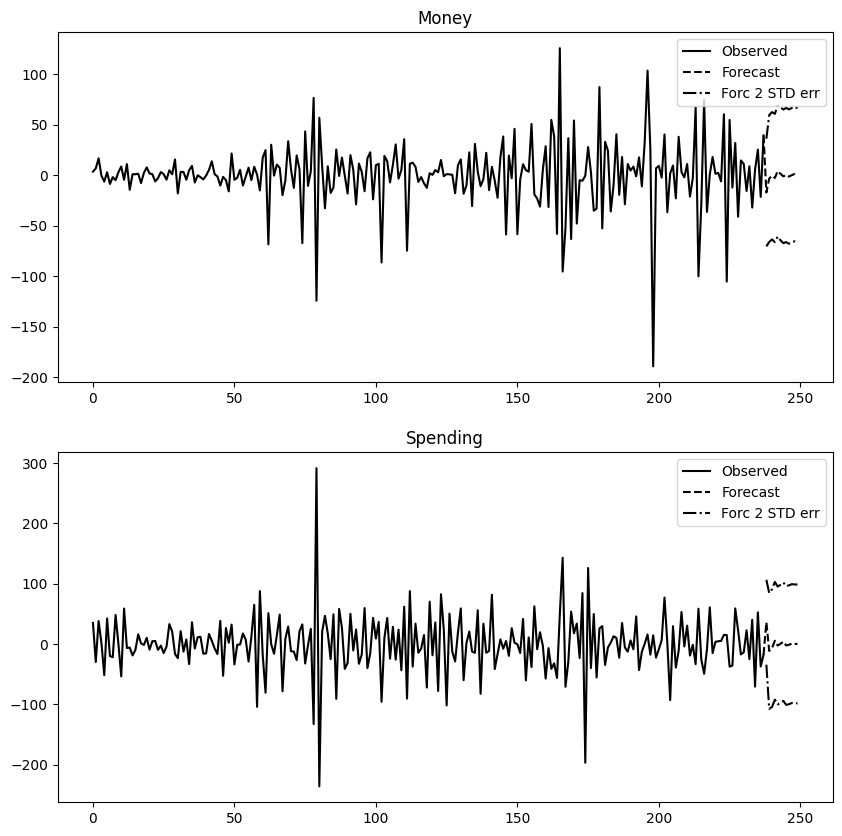

In [55]:
# 예측 포함 시각화
results.plot_forecast(12);

In [47]:
# Test 데이터셋과 예측 결과 비교 시각화
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Money'][-nobs:], name='Money'), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['MoneyForecast'], name='Money Forecast'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Spending'][-nobs:], name='Spending'), row=2, col=1)
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['SpendingForecast'], name='Spending Forecast'), row=2, col=1)
fig.update_layout(height=800)
fig.show()

평가

In [49]:
VAR5_RMSE_Money = rmse(df['Money'][-nobs:], forecast_df['MoneyForecast'])
VAR5_RMSE_Spending = rmse(df['Spending'][-nobs:], forecast_df['SpendingForecast'])
print(f"VAR(5)_RMSE_Money: {VAR5_RMSE_Money}")
print(f"VAR(5)_RMSE_Spending: {VAR5_RMSE_Spending}")

VAR(5)_RMSE_Money: 43.710496535589265
VAR(5)_RMSE_Spending: 37.001175169408036


### AR(5) 모델과 비교

In [50]:
# 앞에서 다루지 않은 부분으로, AR만 단독 사용시 사용할수 있는 모듈
from statsmodels.tsa.ar_model import AutoReg 

모델링 및 예측

In [51]:
# 단일 시계열 모델이므로 모델이 2개 필요
modelM = AutoReg(train['Money'], lags=5)
modelS = AutoReg(train['Spending'], lags=5)
modelM_fit = modelM.fit()
modelS_fit = modelS.fit()
modelM_forecast = modelM_fit.forecast(steps=nobs).rename('Money2d')
modelS_forecast = modelS_fit.forecast(steps=nobs).rename('Spending2d')

In [52]:
ar_forecast_df = pd.concat([modelM_forecast, modelS_forecast], axis=1)
ar_forecast_df

,Money2d,Spending2d
2015-01-01,-17.119701,30.641068
2015-02-01,-11.528475,-1.792151
2015-03-01,9.827790,-9.189819
2015-04-01,-5.836863,6.747310
2015-05-01,2.339541,-4.427224
2015-06-01,5.375022,-0.626697
2015-07-01,-4.165296,3.493390
2015-08-01,0.501917,-0.933378
2015-09-01,0.898255,-0.926789
2015-10-01,-1.352987,0.963593


역변환

In [53]:
ar_forecast_df['Money1d'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + ar_forecast_df['Money2d'].cumsum()
ar_forecast_df['MoneyForecast'] = df['Money'].iloc[-nobs-1] + ar_forecast_df['Money1d'].cumsum()

ar_forecast_df['Spending1d'] = (df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2]) + ar_forecast_df['Spending2d'].cumsum()
ar_forecast_df['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + ar_forecast_df['Spending1d'].cumsum()

In [54]:
ar_forecast_df

,Money2d,Spending2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-17.119701,30.641068,61.480299,11731.580299,41.241068,12103.241068
2015-02-01,-11.528475,-1.792151,49.951824,11781.532123,39.448917,12142.689985
2015-03-01,9.827790,-9.189819,59.779614,11841.311736,30.259098,12172.949083
2015-04-01,-5.836863,6.747310,53.942751,11895.254487,37.006408,12209.955491
2015-05-01,2.339541,-4.427224,56.282292,11951.536779,32.579184,12242.534675
2015-06-01,5.375022,-0.626697,61.657314,12013.194093,31.952487,12274.487162
2015-07-01,-4.165296,3.493390,57.492019,12070.686112,35.445877,12309.933039
2015-08-01,0.501917,-0.933378,57.993936,12128.680048,34.512499,12344.445539
2015-09-01,0.898255,-0.926789,58.892191,12187.572238,33.585710,12378.031249
2015-10-01,-1.352987,0.963593,57.539203,12245.111442,34.549303,12412.580551


결과 시각화

In [65]:
# 차트
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Money'][-nobs:], name='Money'), row=1, col=1)
fig.add_trace(go.Scatter(x=ar_forecast_df.index, y=ar_forecast_df['MoneyForecast'], name='Money Forecast'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index[-nobs:], y=df['Spending'][-nobs:], name='Spending'), row=2, col=1)
fig.add_trace(go.Scatter(x=ar_forecast_df.index, y=ar_forecast_df['SpendingForecast'], name='Spending Forecast'), row=2, col=1)
fig.update_layout(height=800)
fig.show()

In [57]:
# AR(5) 평가 결과
AR5_RMSE_Money = rmse(df['Money'][-nobs:], ar_forecast_df['MoneyForecast'])
AR5_RMSE_Spending = rmse(df['Spending'][-nobs:], ar_forecast_df['SpendingForecast'])
print('-'*100)
print(f"AR(5) RMSE Money: {AR5_RMSE_Money}")
print(f"AR(5) RMSE Spending: {AR5_RMSE_Spending}")
print('-'*100)
print(f"VAR(5) RMSE Money: {VAR5_RMSE_Money}")
print(f"VAR(5) RMSE Spending: {VAR5_RMSE_Spending}")
print('-'*100)

----------------------------------------------------------------------------------------------------
AR(5) RMSE Money: 34.3936979839303
AR(5) RMSE Spending: 34.26101949655065
----------------------------------------------------------------------------------------------------
VAR(5) RMSE Money: 43.710496535589265
VAR(5) RMSE Spending: 37.001175169408036
----------------------------------------------------------------------------------------------------


다변량 시계열 모델이 데이터 적합에서 더 나쁘게 나왔다. 

VAR(5) 모델에서 에러항을 설명할 다른 설명변수가 필요할수 있다.

___
## VARMA / ARIMA 예측 모델 실습
___

모델 추천

In [64]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [59]:
import pmdarima as pm
# pmdarima는 시계열 데이터의 ARIMA 모델을 자동으로 생성해주는 라이브러리.
# 이 라이브러리는 데이터의 최적의 ARIMA 파라미터를 찾기 위해 다양한 조합을 시도하고,
# AIC (Akaike Information Criterion) 값을 기준으로 최적의 모델을 선택해줌.
# 또한, pmdarima는 계절성 데이터에 대한 SARIMA 모델도 지원하며, 
# 데이터의 정상성을 확인하고 차분을 통해 비정상성 제거 기능도 포함.
# 이 라이브러리를 사용하면 복잡한 시계열 모델링 과정을 자동화할 수 있어
# 데이터 과학자와 분석가에게 매우 유용함.

In [60]:
pm.auto_arima(df['Money'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [61]:
pm.auto_arima(df['Spending'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

단일 시계열 모델 ARIMA(1,2,1)과 (1,1,2)가 각 변수에 추천되었다.

2차 차분을 한뒤에, 위 p, q항을 포괄할수 있는 VARMA(1,2) 모델을 통해서 예측을 진행하고 ARIMA와 비교해보자.

데이터 차분

In [62]:
df_transformed = df.diff().diff().dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


데이터 분할

In [ ]:
nobs = 12 # nobs : number of observations
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

모델링

In [65]:
varma = VARMAX(train, order=(1,2), trend='c')
results = varma.fit(maxiter=1000, disp=False)
results.summary()

/Users/dante/lecture/kmu-practical-ds-2024/.conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.399
,+ intercept,AIC,4606.798
Date:,"Thu, 13 Jun 2024",BIC,4665.827
Time:,16:40:18,HQIC,4630.588
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.16, 0.03",Jarque-Bera (JB):,"572.28, 134.46"
Prob(Q):,"0.69, 0.86",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.72, 2.90",Skew:,"1.34, -0.38"


예측

In [66]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-14.039287,38.789965
2015-02-01,-10.954786,-6.628781
2015-03-01,1.935884,0.334886
2015-04-01,-1.768246,-0.577485
2015-05-01,1.267530,0.528682
2015-06-01,-0.571431,-0.100019
2015-07-01,0.617467,0.312901
2015-08-01,-0.139460,0.050956
2015-09-01,0.344160,0.218460
2015-10-01,0.035417,0.111546


차분 역변환

In [71]:
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-14.039287,38.789965,64.560713,11734.660713,49.389965,12111.389965
2015-02-01,-10.954786,-6.628781,53.605927,11788.266640,42.761183,12154.151148
2015-03-01,1.935884,0.334886,55.541811,11843.808451,43.096070,12197.247217
2015-04-01,-1.768246,-0.577485,53.773565,11897.582016,42.518585,12239.765802
2015-05-01,1.267530,0.528682,55.041095,11952.623111,43.047267,12282.813069
2015-06-01,-0.571431,-0.100019,54.469664,12007.092775,42.947248,12325.760317
2015-07-01,0.617467,0.312901,55.087132,12062.179907,43.260149,12369.020466
2015-08-01,-0.139460,0.050956,54.947672,12117.127579,43.311105,12412.331571
2015-09-01,0.344160,0.218460,55.291832,12172.419410,43.529565,12455.861136
2015-10-01,0.035417,0.111546,55.327249,12227.746659,43.641111,12499.502247


데이터 정리 / 결과 시각화

In [72]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-14.039287,38.789965,64.560713,11734.660713,49.389965,12111.389965
2015-02-01,-10.954786,-6.628781,53.605927,11788.266640,42.761183,12154.151148
2015-03-01,1.935884,0.334886,55.541811,11843.808451,43.096070,12197.247217
2015-04-01,-1.768246,-0.577485,53.773565,11897.582016,42.518585,12239.765802
2015-05-01,1.267530,0.528682,55.041095,11952.623111,43.047267,12282.813069
2015-06-01,-0.571431,-0.100019,54.469664,12007.092775,42.947248,12325.760317
2015-07-01,0.617467,0.312901,55.087132,12062.179907,43.260149,12369.020466
2015-08-01,-0.139460,0.050956,54.947672,12117.127579,43.311105,12412.331571
2015-09-01,0.344160,0.218460,55.291832,12172.419410,43.529565,12455.861136
2015-10-01,0.035417,0.111546,55.327249,12227.746659,43.641111,12499.502247


In [74]:
# 두 변수에 대한 테스트셋과 예측치만 남기고 정리
df_forecast = pd.concat([df[['Money', 'Spending']].iloc[-nobs:], df_forecast[['MoneyForecast', 'SpendingForecast']]], axis=1)

In [75]:
df_forecast[['Money', 'MoneyForecast']].iplot()

In [ ]:
df_forecast[['Spending', 'SpendingForecast']].iplot()

In [76]:
varma_1_2_money_rmse = rmse(df[['Money']].iloc[-nobs:], df_forecast[['MoneyForecast']])[0]
varma_1_2_spending_rmse = rmse(df[['Spending']].iloc[-nobs:], df_forecast[['SpendingForecast']])[0]
print('VARMA(1,2) Money RMSE: ', varma_1_2_money_rmse)
print('VARMA(1,2) Spending RMSE: ', varma_1_2_spending_rmse)

VARMA(1,2) Money RMSE:  25.81445419926364
VARMA(1,2) Spending RMSE:  63.0386839402952


### ARMA(1,0,2) 비교
* 위에서 train, test 데이터를 만들때 2차 차분을 이미 진행했으므로 ARIMA(1,2,2) 를 사용하지 않고 ARMA(1,0,2) 사용한다.

In [82]:
from statsmodels.tsa.arima.model import ARIMA

모델링 / 적합

In [89]:
# money 컬럼 모델
arma_money_model = ARIMA(train['Money'], order=(1,0,2))
arma_money_model_fit = arma_money_model.fit()
arma_money_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1117.710
Date:                Thu, 13 Jun 2024   AIC                           2245.421
Time:                        16:56:47   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1814      0.032      5.638      0.000       0.118       0.244
ar.L1         -0.3567      0.176     -2.030      0.042      -0.701      -0.012
ma.L1         -0.4088      2.993     -0.137      0.891      -6.274       5.457
ma.L2         -0.5912      1.722     -0.343      0.731      -3.967       2.784
sigma2       687.1912   2035.006      0.338      0.736   -3301.347    4675.729
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               775.27
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               6.83   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
# spending 컬럼 모델
arma_spending = ARIMA(train['Spending'], order=(1,0,2))
arma_spending_fit = arma_spending.fit()
arma_spending_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1182.411
Date:                Thu, 13 Jun 2024   AIC                           2374.823
Time:                        16:57:11   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0856      0.279      0.307      0.759      -0.461       0.632
ar.L1         -0.3403      0.545     -0.624      0.532      -1.408       0.728
ma.L1         -0.6451      0.549     -1.174      0.240      -1.722       0.432
ma.L2         -0.2139      0.507     -0.422      0.673      -1.207       0.779
sigma2      1201.3966     66.509     18.064      0.000    1071.042    1331.751
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               184.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

예측

In [91]:
arma_money2d_forecast = arma_model_fit.forecast(steps=nobs).rename('Forecast_Money2d')
arma_spending2d_forecast = arma_spending_fit.forecast(steps=nobs).rename('Forecast_Spending2d')

차분 역변환

In [92]:
money1d = df['Money'].iloc[-nobs-1] - df['Money'].iloc[-nobs-2] + arma_money2d_forecast.cumsum()
money_forecast = df['Money'].iloc[-nobs-1] + money1d.cumsum()

spending1d = df['Spending'].iloc[-nobs-1] - df['Spending'].iloc[-nobs-2] + arma_spending2d_forecast.cumsum()
spending_forecast = df['Spending'].iloc[-nobs-1] + spending1d.cumsum()

평가

In [94]:
arma_money_rmse = rmse(df['Money'][-nobs:], money_forecast)
arma_spending_rmse = rmse(df['Spending'][-nobs:], spending_forecast)
print('-'*100)
print(f"AR(5) RMSE Money: {AR5_RMSE_Money}")
print(f"AR(5) RMSE Spending: {AR5_RMSE_Spending}")
print('-'*100)
print(f"VAR(5) RMSE Money: {VAR5_RMSE_Money}")
print(f"VAR(5) RMSE Spending: {VAR5_RMSE_Spending}")
print('-'*100)
print(f"ARMA(1,0,2) Money RMSE: {arma_money_rmse}")
print(f"ARMA(1,0,2) Spending RMSE: {arma_spending_rmse}")
print('-'*100)
print('VARMA(1,2) Money RMSE: ', varma_1_2_money_rmse)
print('VARMA(1,2) Spending RMSE: ', varma_1_2_spending_rmse)
print('-'*100)


----------------------------------------------------------------------------------------------------
AR(5) RMSE Money: 34.3936979839303
AR(5) RMSE Spending: 34.26101949655065
----------------------------------------------------------------------------------------------------
VAR(5) RMSE Money: 43.710496535589265
VAR(5) RMSE Spending: 37.001175169408036
----------------------------------------------------------------------------------------------------
ARMA(1,0,2) Money RMSE: 32.68817897263541
ARMA(1,0,2) Spending RMSE: 52.33218479782262
----------------------------------------------------------------------------------------------------
VARMA(1,2) Money RMSE:  25.81445419926364
VARMA(1,2) Spending RMSE:  63.0386839402952
----------------------------------------------------------------------------------------------------


In [97]:
pd.DataFrame({'AR(5)': [AR5_RMSE_Money, AR5_RMSE_Spending],
              'VAR(5)': [VAR5_RMSE_Money, VAR5_RMSE_Spending],
              'ARMA(1,0,2)': [arma_money_rmse, arma_spending_rmse],
              'VARMA(1,2)': [varma_1_2_money_rmse, varma_1_2_spending_rmse]},
              index=['Money', 'Spending']).T.iplot(kind='bar', title='평가결과 비교', xTitle='모델', yTitle='RMSE')